In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import staintools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
features_df = pd.read_csv("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/NBTClassifier_512px_externaltesting.csv")

In [3]:
tsne_df = features_df.copy()
embedding_columns = [col for col in tsne_df.columns if col.startswith('feature_')]
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(tsne_df.loc[:, embedding_columns])

tsne_df["tsne1"] = -projections[:,0]
tsne_df["tsne2"] = -projections[:,1]
tsne_df.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'true_label', 'TC_epi', 'TC_str', 'TC_adi', 'TC_pred', 'cohort',
       'tsne1', 'tsne2', 'confidence', 'misclassified'],
      dtype='object', length=523)

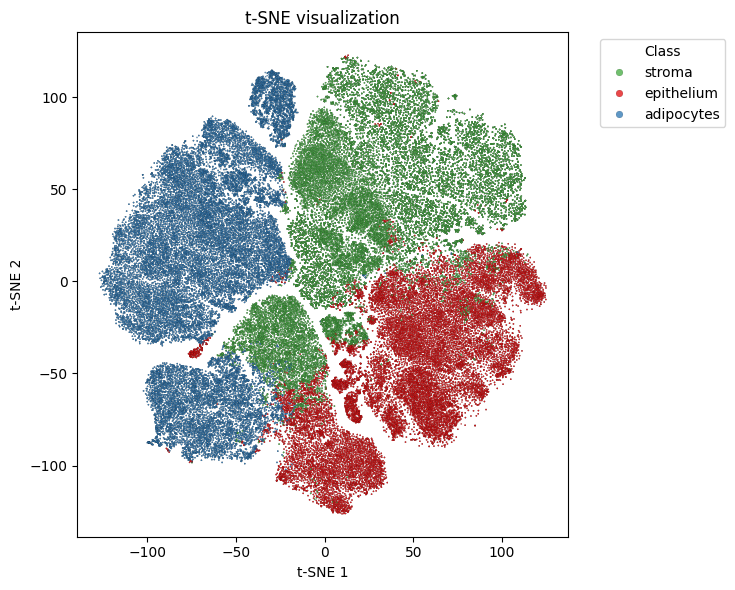

In [4]:
set1_palette = sns.color_palette('Set1', n_colors=3)
custom_palette = {'epithelium': set1_palette[0],  # Red
                  'stroma': set1_palette[2],      # Green
                  'adipocytes': set1_palette[1]}     # Blue

plt.figure(figsize=(7.5, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='TC_pred', palette=custom_palette, s=1, edgecolor='k', alpha=0.8)

plt.title("t-SNE visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
plt.tight_layout()
plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_predictions.png", dpi=300)
# plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_predictions.pdf", format="pdf")
plt.show()

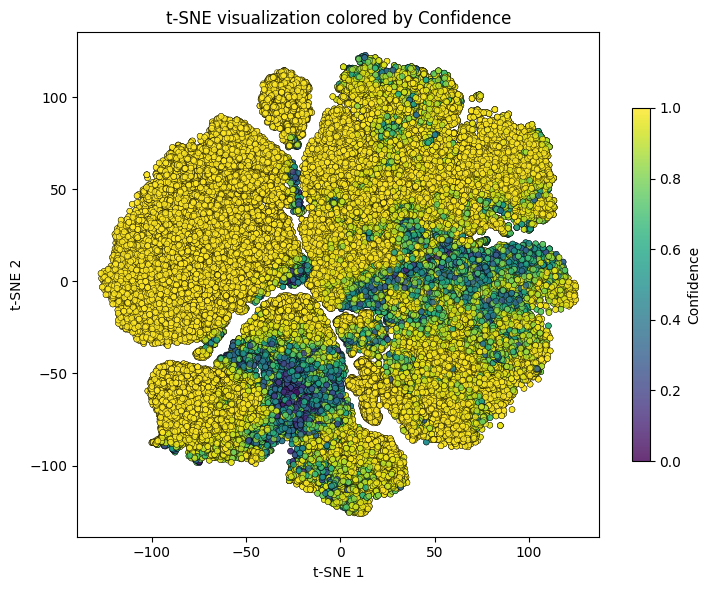

In [5]:
viridis_cmap = sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(7.5, 6))
scatter = sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='confidence', palette=viridis_cmap, 
                          size=0.1, edgecolor='k', alpha=0.8, legend=None)

plt.colorbar(scatter.collections[0], label="Confidence", shrink=0.7)
plt.title("t-SNE visualization colored by Confidence")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_confidence.png", dpi=300)
# plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_confidence.pdf", format="pdf")
plt.show()

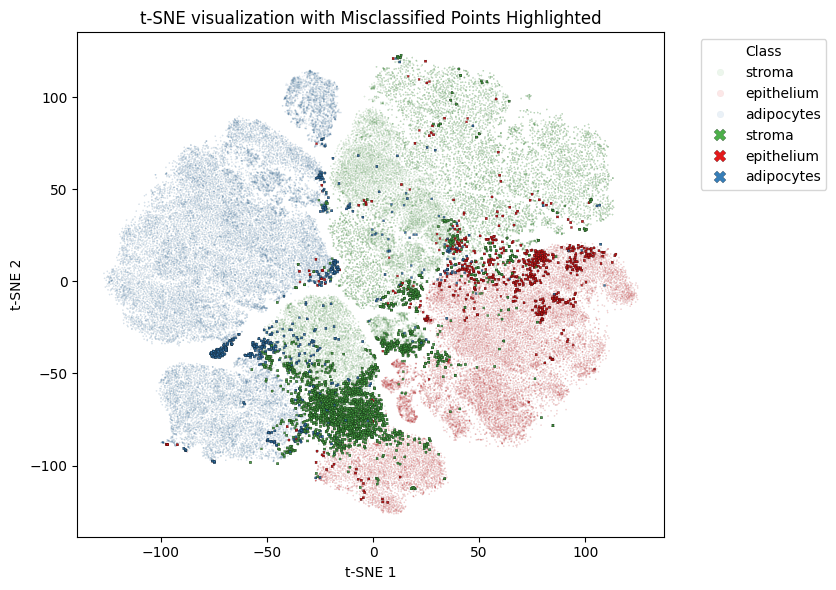

In [6]:
plt.figure(figsize=(8.5, 6))

sns.scatterplot(data=tsne_df[~tsne_df['misclassified']], x='tsne1', y='tsne2', hue='true_label', 
                palette=custom_palette, s=1, edgecolor='k', alpha=0.1, marker='o')

sns.scatterplot(data=tsne_df[tsne_df['misclassified']], x='tsne1', y='tsne2', hue='true_label', 
                palette=custom_palette, s=3, edgecolor='k', alpha=1.0, marker='X')

plt.title("t-SNE visualization with Misclassified Points Highlighted")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
plt.tight_layout()
plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_groundtruth.png", dpi=300)
# plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_coloredby_groundtruth.pdf", format="pdf")
plt.show()

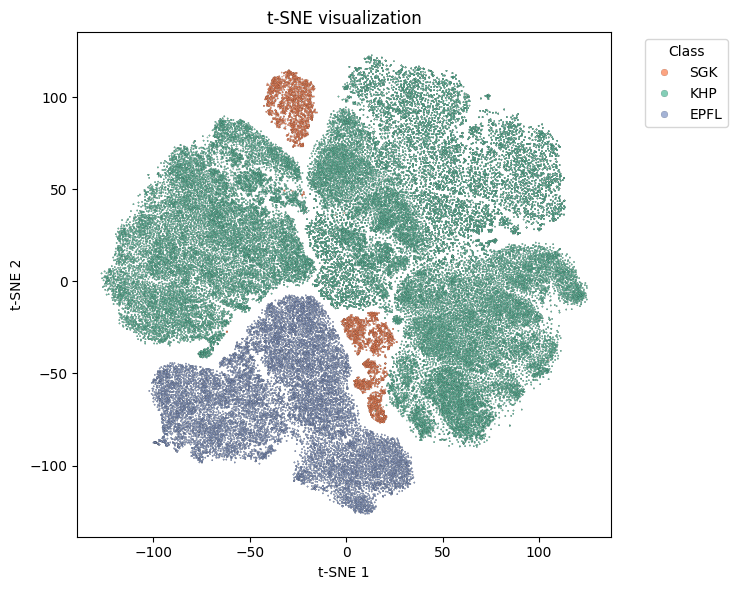

In [7]:
set1_palette = sns.color_palette('Set2', n_colors=3)
custom_palette = {'KHP': set1_palette[0],  
                  'SGK': set1_palette[1],      
                  'EPFL': set1_palette[2]}    

plt.figure(figsize=(7.5, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cohort', palette=custom_palette, s=1, edgecolor='k', alpha=0.8)
plt.title("t-SNE visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
plt.tight_layout()
plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_cohort.png", dpi=300)
# plt.savefig("/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_cohort.pdf", format="pdf")
plt.show()

In [8]:
max_dim = 100
width, height = (2000, 2000)
random_state = 42
random.seed(random_state)

# Sample 500 im_paths per cluster
random_df = tsne_df.groupby('true_label').apply(lambda group: group.sample(n=500, replace=True, random_state=random_state))

# Reset the index to avoid multi-index
random_df = random_df.reset_index(drop=True)

# Normalize t-SNE projections to [0, 1] for consistent positioning
tx, ty = random_df["tsne1"], random_df["tsne2"]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

# Initialize the canvas
full_image = Image.new('RGBA', (width, height))

for im_path, tsne_x, tsne_y, cluster_id in zip(random_df['file_path'], tx, ty, random_df['true_label']):
    im = Image.open(im_path)
    
    # Resize image to fit within the max dimension
    rs = max(1, im.width / max_dim, im.height / max_dim)
    tile = im.resize((int(im.width / rs), int(im.height / rs)))

    # Normalize t-SNE coordinates to canvas dimensions
    x_pos = int(tsne_x * (width - tile.width))  # Scale the x coordinate to canvas size
    y_pos = int(tsne_y * (height - tile.height))  # Scale the y coordinate to canvas size

    # Paste the resized tile on the canvas
    full_image.paste(tile, (x_pos, y_pos))
    
full_image.save('/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_HEOverlay.png')

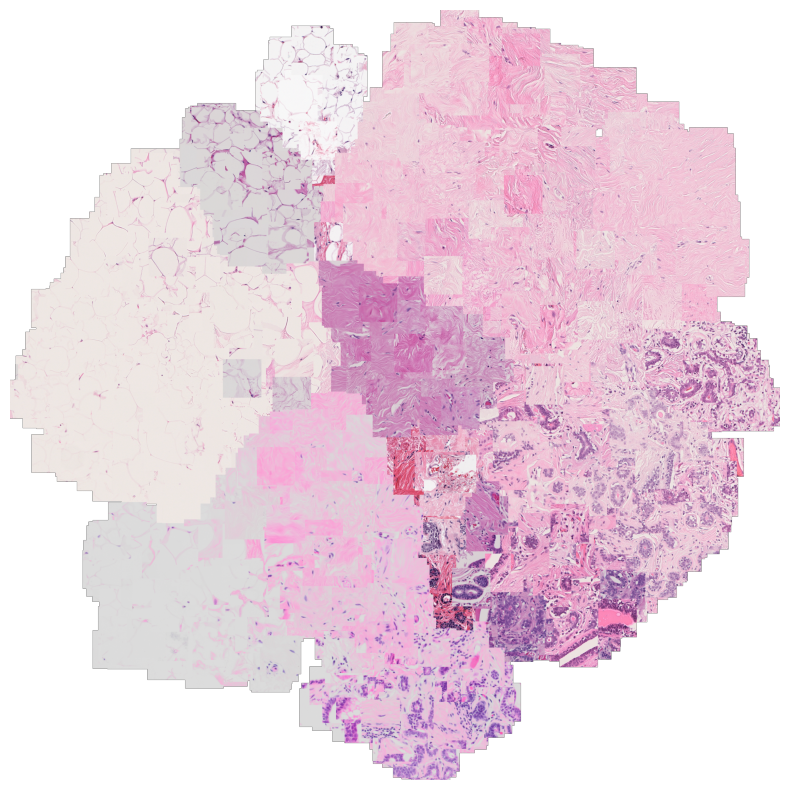

In [11]:
full_image = Image.open('/scratch_tmp/prj/cb_normalbreast/prj_NBTClassifier/TC512_tsne_HEOverlay.png')
flipped_image = full_image.transpose(Image.FLIP_TOP_BOTTOM)

plt.figure(figsize=(12, 10))
plt.imshow(flipped_image)
plt.axis('off')  # Optional: removes axis for a cleaner look
plt.show()